# Statistical Debugging

Let us correlate events with failures!

**Prerequisites**

* You should have read the [Chapter on Tracing](Tracer.ipynb).

In [1]:
import bookutils

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.StatisticalDebugger import <identifier>
```

and then make use of the following features.


_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

For instance, this is what we get for `x=1`:

You can use `int_fuzzer()` as:

```python
>>> print(2 + 2)
4
```


## All these Events!


We start with a base class to collect events:

In [2]:
from Tracer import Tracer

In [3]:
class Collector(Tracer):
    """A class to record events during execution."""

    def collect(self, frame, event, arg):
        """Collecting function. To be overridden in subclasses."""
        pass

    def traceit(self, frame, event, arg):
        self.collect(frame, event, arg)

In [4]:
class Collector(Collector):
    def __init__(self):
        self._id = None

    def traceit(self, frame, event, arg):
        if self._id is None and event == "call":
            function = frame.f_code.co_name
            locals = frame.f_locals
            args = ", ".join([f"{var}={repr(locals[var])}" for var in locals])
            self._id = f"{function}({args})"

        self.collect(frame, event, arg)

    def id(self):
        return self._id

In [5]:
from Intro_Debugging import remove_html_markup

In [6]:
with Collector():
    remove_html_markup('abc')

Let's extend this to collect coverage:

In [7]:
class CoverageCollector(Collector):
    def __init__(self):
        super().__init__()
        self.coverage = set()

    def collect(self, frame, event, arg):
        self.coverage.add(frame.f_lineno)

In [8]:
class CoverageCollector(CoverageCollector):
    def events(self):
        """Return a set of predicates holding for the execution"""
        return self.coverage

In [9]:
c = CoverageCollector()
with c:
    remove_html_markup('abc')
print(c.events())

{161, 163, 165, 167, 168, 170, 153, 154, 155, 156, 158, 159}


In [10]:
print(c.id())

remove_html_markup(s='abc')


In [11]:
import inspect

In [12]:
def list_with_coverage(function, coverage):
    source_lines, starting_line_number = \
       inspect.getsourcelines(function)

    line_number = starting_line_number
    for line in source_lines:
        marker = '*' if line_number in coverage else ' '
        print(f"{line_number:4} {marker} {line}", end='')
        line_number += 1

In [13]:
list_with_coverage(remove_html_markup, c.coverage)

 153 * def remove_html_markup(s):
 154 *     tag = False
 155 *     quote = False
 156 *     out = ""
 157   
 158 *     for c in s:
 159 *         assert tag or not quote
 160   
 161 *         if c == '<' and not quote:
 162               tag = True
 163 *         elif c == '>' and not quote:
 164               tag = False
 165 *         elif (c == '"' or c == "'") and tag:
 166               quote = not quote
 167 *         elif not tag:
 168 *             out = out + c
 169   
 170 *     return out


The interesting part are those lines _not_ covered.

## Computing Differences

In [14]:
c = CoverageCollector()
with c:
    remove_html_markup('abc')
print(c.events())

{161, 163, 165, 167, 168, 170, 153, 154, 155, 156, 158, 159}


In [15]:
class StatisticalDebugger():
    def __init__(self, collector_class):
        self.collector_class = collector_class
        self.collectors = {}

In [16]:
class StatisticalDebugger(StatisticalDebugger):
    def collect(self, name, *args):
        collector = self.collector_class(*args)
        if name not in self.collectors:
            self.collectors[name] = []
        self.collectors[name].append(collector)
        return collector

In [17]:
from IPython.display import display, Markdown, HTML

In [18]:
class StatisticalDebugger(StatisticalDebugger):
    def event_table(self, show_ids=False):
        sep = ' | '

        all_events = set()
        for name in self.collectors:
            for collector in self.collectors[name]:
                all_events.update(collector.events())

        longest_event = max(len(f"{event}") for event in all_events)

        out = ""

        # Header
        if show_ids:
            out += '| ' + ' ' * longest_event + sep
            for name in self.collectors:
                for collector in self.collectors[name]:
                    out += '`' + collector.id() + '`' + sep
            out += '\n'
        else:
            out += '| ' + ' ' * longest_event + sep
            for name in self.collectors:
                for i in range(len(self.collectors[name])):
                    out += name + sep
            out += '\n'

        out += '| ' + '-' * longest_event + sep
        for name in self.collectors:
            for i in range(len(self.collectors[name])):
                out += '-' * len(name) + sep
        out += '\n'

        # Data
        for event in all_events:
            out += f"| {repr(event).rjust(longest_event)}" + sep
            for name in self.collectors:
                for collector in self.collectors[name]:
                    out += ' ' * (len(name) - 1)
                    if event in collector.events():
                        out += "X"
                    else:
                        out += "-"
                    out += sep
            out += '\n'

        return Markdown(out)

In [19]:
class DifferenceDebugger(StatisticalDebugger):
    PASS = 'pass'
    FAIL = 'fail'

    def collect_pass(self):
        return self.collect(self.PASS)
    def collect_fail(self):
        return self.collect(self.FAIL)

    def pass_collectors(self):
        return self.collectors[self.PASS]
    def fail_collectors(self):
        return self.collectors[self.FAIL]

In [20]:
def test_debugger_html(debugger):
    with debugger.collect_pass():
        remove_html_markup('abc')
    with debugger.collect_pass():
        remove_html_markup('<b>abc</b>')
    with debugger.collect_fail():
        remove_html_markup('<b bar="foo"></b>')
    return debugger

In [21]:
debugger = test_debugger_html(DifferenceDebugger(CoverageCollector))

In [22]:
debugger.event_table()

|     | pass | pass | fail | 
| --- | ---- | ---- | ---- | 
| 153 |    X |    X |    X | 
| 154 |    X |    X |    X | 
| 155 |    X |    X |    X | 
| 156 |    X |    X |    X | 
| 158 |    X |    X |    X | 
| 159 |    X |    X |    X | 
| 161 |    X |    X |    X | 
| 162 |    - |    X |    X | 
| 163 |    X |    X |    X | 
| 164 |    - |    X |    X | 
| 165 |    X |    X |    X | 
| 166 |    - |    - |    X | 
| 167 |    X |    X |    X | 
| 168 |    X |    X |    - | 
| 170 |    X |    X |    X | 


In [23]:
pass_1_events = debugger.pass_collectors()[0].events()

In [24]:
pass_2_events = debugger.pass_collectors()[1].events()

In [25]:
in_any_pass = pass_1_events | pass_2_events
in_any_pass

{153, 154, 155, 156, 158, 159, 161, 162, 163, 164, 165, 167, 168, 170}

In [26]:
fail_events = debugger.fail_collectors()[0].events()

In [27]:
only_in_fail = fail_events - in_any_pass
only_in_fail

{166}

In [28]:
list_with_coverage(remove_html_markup, only_in_fail)

 153   def remove_html_markup(s):
 154       tag = False
 155       quote = False
 156       out = ""
 157   
 158       for c in s:
 159           assert tag or not quote
 160   
 161           if c == '<' and not quote:
 162               tag = True
 163           elif c == '>' and not quote:
 164               tag = False
 165           elif (c == '"' or c == "'") and tag:
 166 *             quote = not quote
 167           elif not tag:
 168               out = out + c
 169   
 170       return out


In [29]:
class DifferenceDebugger(DifferenceDebugger):
    def all_events(self, category=None):
        in_any = set()
        if category:
            for collector in self.collectors[category]:
                in_any.update(collector.events())
        else:
            for category in self.collectors:
                for collector in self.collectors[category]:
                    in_any.update(collector.events())
        return in_any

    def all_fail(self):
        return self.all_events(self.FAIL)

    def all_pass(self):
        return self.all_events(self.PASS)

    def only_fail(self):
        return self.all_fail() - self.all_pass()

    def only_pass(self):
        return self.all_pass() - self.all_fail()

In [30]:
debugger = test_debugger_html(DifferenceDebugger(CoverageCollector))

In [31]:
debugger.all_events()

{153, 154, 155, 156, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 170}

In [32]:
debugger.only_fail()

{166}

In [33]:
debugger.only_pass()

{168}

## Visualizing Differences

### Discrete Spectrum

In [34]:
class DiscreteSpectrumDebugger(DifferenceDebugger):
    def color(self, line_number):
        passing = self.all_events(self.PASS)
        failing = self.all_events(self.FAIL)

        if line_number in passing and line_number in failing:
            return 'lightyellow'
        elif line_number in failing:
            return 'mistyrose'
        elif line_number in passing:
            return 'honeydew'
        else:
            return None

In [35]:
class DiscreteSpectrumDebugger(DiscreteSpectrumDebugger):
    def list_with_spectrum(self, function):
        source_lines, starting_line_number = \
           inspect.getsourcelines(function)

        line_number = starting_line_number
        out = ""
        for line in source_lines:
            if line.strip() == '':
                line = '&nbsp;'

            line = str(line_number).rjust(4) + ' ' + line

            color = self.color(line_number)
            if color:
                line = f'<pre style="background-color:{color}">' \
                        f'{line.rstrip()}</pre>'
            else:
                line = f'<pre>{line}</pre>'

            out += line
            line_number += 1

        return HTML(out)

In [36]:
debugger = test_debugger_html(DiscreteSpectrumDebugger(CoverageCollector))

In [37]:
debugger.list_with_spectrum(remove_html_markup)

### Continuous Spectrum

We introduce the Tarantula method for highlighting differences. The color is defined as follows:

$$\textit{color}(\textit{line}) = \textit{low color(red)} + \frac{\%\textit{passed}(\textit{line})}{\%\textit{passed}(\textit{line}) + \%\textit{failed}(\textit{line})} \times \textit{color range}$$

In [38]:
class ContinuousSpectrumDebugger(DiscreteSpectrumDebugger):
    def event_fraction(self, event, category):
        all_runs = self.collectors[category]
        runs_with_event = set(collector for collector in all_runs 
                              if event in collector.events())
        fraction = len(runs_with_event) / len(all_runs)
        # print(f"%{category}({event}) = {fraction}")
        return fraction

    def passed(self, line_number):
        return self.event_fraction(line_number, self.PASS)

    def failed(self, line_number):
        return self.event_fraction(line_number, self.FAIL)

    def hue(self, line_number):
        passed = self.passed(line_number)
        failed = self.failed(line_number)
        if passed + failed > 0:
            return passed / (passed + failed)
        else:
            return None

In [39]:
debugger = test_debugger_html(ContinuousSpectrumDebugger(CoverageCollector))

In [40]:
for line in debugger.only_fail():
    print(line, debugger.hue(line))

166 0.0


In [41]:
for line in debugger.only_pass():
    print(line, debugger.hue(line))

168 1.0


The brightness is defined as follows:

$$\textit{bright}(line) = \max(\%\textit{passed}(\textit{line}), \%\textit{failed}(\textit{line}))$$

In [42]:
class ContinuousSpectrumDebugger(ContinuousSpectrumDebugger):
    def bright(self, line):
        return max(self.passed(line), self.failed(line))

In [43]:
debugger = test_debugger_html(ContinuousSpectrumDebugger(CoverageCollector))
for line in debugger.only_fail():
    print(line, debugger.bright(line))

166 1.0


In [44]:
class ContinuousSpectrumDebugger(ContinuousSpectrumDebugger):
    def color(self, line):
        hue = debugger.hue(line)
        if hue is None:
            return None
        saturation = debugger.bright(line)

        # HSL color values are specified with: 
        # hsl(hue, saturation, lightness).
        return f"hsl({hue * 120}, {saturation * 100}%, 80%)"

In [45]:
debugger = test_debugger_html(ContinuousSpectrumDebugger(CoverageCollector))

In [46]:
for line in debugger.only_fail():
    print(line, debugger.color(line))

166 hsl(0.0, 100.0%, 80%)


In [47]:
for line in debugger.only_pass():
    print(line, debugger.color(line))

168 hsl(120.0, 100.0%, 80%)


In [48]:
debugger.list_with_spectrum(remove_html_markup)

Here's another example (right from the Tarantula paper source):

In [49]:
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    else:
        if x > y:
            return y
        elif x > z:
            return x
    return z

In [50]:
def test_debugger_middle(debugger):
    with debugger.collect_pass():
        middle(3, 3, 5)
    with debugger.collect_pass():
        middle(1, 2, 3)
    with debugger.collect_pass():
        middle(3, 2, 1)
    with debugger.collect_pass():
        middle(5, 5, 5)
    with debugger.collect_pass():
        middle(5, 3, 4)
    with debugger.collect_fail():
        middle(2, 1, 3)
    return debugger

Note that in order to collect data from multiple function invocations, you need to have a separate `with` clause for every invocation. The following will _not_ work correctly:

```python
    with debugger.collect_pass():
        middle(3, 3, 5)
        middle(1, 2, 3)
        ...
```

In [51]:
debugger = test_debugger_middle(ContinuousSpectrumDebugger(CoverageCollector))

In [52]:
debugger.event_table()

|    | pass | pass | pass | pass | pass | fail | 
| -- | ---- | ---- | ---- | ---- | ---- | ---- | 
|  1 |    X |    X |    X |    X |    X |    X | 
|  2 |    X |    X |    X |    X |    X |    X | 
|  3 |    X |    X |    - |    - |    X |    X | 
|  4 |    - |    X |    - |    - |    - |    - | 
|  5 |    X |    - |    - |    - |    X |    X | 
|  6 |    X |    - |    - |    - |    - |    X | 
|  8 |    - |    - |    X |    X |    - |    - | 
|  9 |    - |    - |    X |    - |    - |    - | 
| 10 |    - |    - |    - |    X |    - |    - | 
| 12 |    - |    - |    - |    X |    X |    - | 


In [53]:
debugger.list_with_spectrum(middle)

## Ranking Lines by Suspiciousness

### The Tarantula Metric

### The Ochiai Metric

### How Effective is Ranking?

## Other Events besides Coverage

Our framework allows for tracking arbitrary events, not just coverage.

In [54]:
class ValueCollector(Collector):
    def __init__(self):
        super().__init__()
        self.vars = set()

    def collect(self, frame, event, arg):
        local_vars = frame.f_locals
        for var in local_vars:
            value = local_vars[var]
            self.vars.add((var, value))

    def events(self):
        return self.vars

In [55]:
debugger = test_debugger_html(DifferenceDebugger(ValueCollector))
debugger.event_table()

|                            | pass | pass | fail | 
| -------------------------- | ---- | ---- | ---- | 
|                 ('c', ' ') |    - |    - |    X | 
|                 ('c', 'c') |    X |    X |    - | 
|            ('quote', True) |    - |    - |    X | 
|               ('out', 'a') |    X |    X |    - | 
|        ('s', '<b>abc</b>') |    - |    X |    - | 
|                 ('c', 'f') |    - |    - |    X | 
|             ('out', 'abc') |    X |    X |    - | 
|                 ('c', '"') |    - |    - |    X | 
|                 ('c', '/') |    - |    X |    X | 
|                 ('c', '<') |    - |    X |    X | 
|                 ('c', '>') |    - |    X |    X | 
|                 ('c', 'r') |    - |    - |    X | 
|              ('out', 'ab') |    X |    X |    - | 
|             ('tag', False) |    X |    X |    X | 
|               ('s', 'abc') |    X |    - |    - | 
|                 ('c', 'a') |    X |    X |    X | 
|           ('quote', False) |    X |    X |    X | 
|                 ('c', 'b') |    X |    X |    X | 
| ('s', '<b bar="foo"></b>') |    - |    - |    X | 
|                 ('c', '=') |    - |    - |    X | 
|                 ('c', 'o') |    - |    - |    X | 
|                ('out', '') |    X |    X |    X | 
|              ('tag', True) |    - |    X |    X | 


In [56]:
debugger.only_fail()

{('c', ' '),
 ('c', '"'),
 ('c', '='),
 ('c', 'f'),
 ('c', 'o'),
 ('c', 'r'),
 ('quote', True),
 ('s', '<b bar="foo"></b>')}

In [57]:
debugger = test_debugger_middle(DifferenceDebugger(ValueCollector))
debugger.event_table()

|          | pass | pass | pass | pass | pass | fail | 
| -------- | ---- | ---- | ---- | ---- | ---- | ---- | 
| ('z', 4) |    - |    - |    - |    - |    X |    - | 
| ('z', 5) |    X |    - |    - |    X |    - |    - | 
| ('y', 5) |    - |    - |    - |    X |    - |    - | 
| ('y', 3) |    X |    - |    - |    - |    X |    - | 
| ('x', 5) |    - |    - |    - |    X |    X |    - | 
| ('x', 3) |    X |    - |    X |    - |    - |    - | 
| ('x', 2) |    - |    - |    - |    - |    - |    X | 
| ('y', 1) |    - |    - |    - |    - |    - |    X | 
| ('x', 1) |    - |    X |    - |    - |    - |    - | 
| ('z', 1) |    - |    - |    X |    - |    - |    - | 
| ('y', 2) |    - |    X |    X |    - |    - |    - | 
| ('z', 3) |    - |    X |    - |    - |    - |    X | 


In [58]:
debugger.only_fail()

{('x', 2), ('y', 1)}

### Training a Classifier

In [59]:
from sklearn import tree

In [60]:
class ClassifyingDebugger(DifferenceDebugger):
    PASS_VALUE = +1
    FAIL_VALUE = -1

    def samples(self):
        samples = {}
        for collector in self.pass_collectors():
            samples[collector.id()] = self.PASS_VALUE
        for collector in debugger.fail_collectors():
            samples[collector.id()] = self.FAIL_VALUE
        return samples

In [61]:
debugger = test_debugger_middle(ClassifyingDebugger(CoverageCollector))
debugger.samples()

{'middle(z=5, y=3, x=3)': 1,
 'middle(z=3, y=2, x=1)': 1,
 'middle(z=1, y=2, x=3)': 1,
 'middle(z=5, y=5, x=5)': 1,
 'middle(z=4, y=3, x=5)': 1,
 'middle(z=3, y=1, x=2)': -1}

In [62]:
class ClassifyingDebugger(ClassifyingDebugger):
    def features(self):
        features = {}
        for collector in debugger.pass_collectors():
            features[collector.id()] = collector.events()
        for collector in debugger.fail_collectors():
            features[collector.id()] = collector.events()
        return features

In [63]:
debugger = test_debugger_middle(ClassifyingDebugger(CoverageCollector))
debugger.features()

{'middle(z=5, y=3, x=3)': {1, 2, 3, 5, 6},
 'middle(z=3, y=2, x=1)': {1, 2, 3, 4},
 'middle(z=1, y=2, x=3)': {1, 2, 8, 9},
 'middle(z=5, y=5, x=5)': {1, 2, 8, 10, 12},
 'middle(z=4, y=3, x=5)': {1, 2, 3, 5, 12},
 'middle(z=3, y=1, x=2)': {1, 2, 3, 5, 6}}

In [64]:
class ClassifyingDebugger(ClassifyingDebugger):
    def feature_names(self):
        return [repr(feature) for feature in self.all_events()]

In [65]:
debugger = test_debugger_middle(ClassifyingDebugger(CoverageCollector))
debugger.feature_names()

['1', '2', '3', '4', '5', '6', '8', '9', '10', '12']

In [66]:
class ClassifyingDebugger(ClassifyingDebugger):
    def shape(self, sample):
        x = []
        features = self.features()
        for f in self.all_events():
            if f in features[sample]:
                x += [+1]
            else:
                x += [-1]
        return x

In [67]:
debugger = test_debugger_middle(ClassifyingDebugger(CoverageCollector))
debugger.shape('middle(z=5, y=3, x=3)')

[1, 1, 1, -1, 1, 1, -1, -1, -1, -1]

In [68]:
class ClassifyingDebugger(ClassifyingDebugger):
    def X(self):
        X = []
        samples = self.samples()
        for key in samples:
            X += [self.shape(key)]
        return X

In [69]:
debugger = test_debugger_middle(ClassifyingDebugger(CoverageCollector))
debugger.X()

[[1, 1, 1, -1, 1, 1, -1, -1, -1, -1],
 [1, 1, 1, 1, -1, -1, -1, -1, -1, -1],
 [1, 1, -1, -1, -1, -1, 1, 1, -1, -1],
 [1, 1, -1, -1, -1, -1, 1, -1, 1, 1],
 [1, 1, 1, -1, 1, -1, -1, -1, -1, 1],
 [1, 1, 1, -1, 1, 1, -1, -1, -1, -1]]

In [70]:
class ClassifyingDebugger(ClassifyingDebugger):
    def Y(self):
        Y = []
        samples = self.samples()
        for key in samples:
            Y += [samples[key]]
        return Y

In [71]:
debugger = test_debugger_middle(ClassifyingDebugger(CoverageCollector))
debugger.Y()

[1, 1, 1, 1, 1, -1]

In [72]:
class ClassifyingDebugger(ClassifyingDebugger):
    def classifier(self):
        classifier = tree.DecisionTreeClassifier()
        classifier = classifier.fit(self.X(), self.Y())
        return classifier

In [73]:
import graphviz

In [74]:
class ClassifyingDebugger(ClassifyingDebugger):
    def show_classifier(self, classifier):
        dot_data = tree.export_graphviz(classifier, out_file=None, 
                         filled=False, rounded=True,
                         feature_names=self.feature_names(),
                                class_names=["fail", "pass"],
                                impurity=False,
                         special_characters=True)
        dot_data = dot_data.replace('&le; 0.0', ': no')
        dot_data = dot_data.replace('&ge; 0.0', ': yes')

        return graphviz.Source(dot_data)

This is the tree we get.  A decision like `* <= 0` means that `*` is not part of the input.

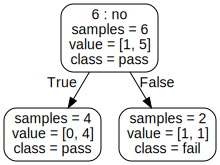

In [75]:
debugger = test_debugger_middle(ClassifyingDebugger(CoverageCollector))
classifier = debugger.classifier()
debugger.show_classifier(classifier)

In [76]:
class ClassifyingDebugger(ClassifyingDebugger):
    def predict(self, classifier, sample):
        return classifier.predict([self.shape(sample)])

In [77]:
debugger = test_debugger_middle(ClassifyingDebugger(CoverageCollector))
# debugger.predict(classifier, set(166))

## Synopsis

_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

For instance, this is what we get for `x=1`:

You can use `int_fuzzer()` as:

In [78]:
print(2 + 2)

4


## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [79]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [80]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

**Solution.** _Solution for the exercise_